In [24]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import keras
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

import os

In [5]:
df2 = pd.read_csv("merged_data.csv", low_memory=False, parse_dates=['datetime'])

# Convert problematic column to a specific type
df2["id"] = df2["id"].astype(str)  # Convert to string
df2["label"] = df2["label"].astype("int32") 

In [6]:
df2.tail(10)

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
11509041,-32.0,-43.0,56.0,3.398877,88.37,33.77,F5,2020-07-23 17:28:59.718749952,2
11509042,-16.0,-52.0,52.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.750000128,2
11509043,-47.0,-78.0,5.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.781250048,2
11509044,-45.0,-77.0,-24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.812499968,2
11509045,-51.0,-77.0,23.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.843749888,2
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2
11509050,-22.0,-24.0,29.0,3.374543,88.33,33.75,F5,2020-07-23 17:29:00.000000000,2


In [7]:
print(df2.dtypes)

X                  float64
Y                  float64
Z                  float64
EDA                float64
HR                 float64
TEMP               float64
id                  object
datetime    datetime64[ns]
label                int32
dtype: object


In [8]:
df2.isna().sum()

X           0
Y           0
Z           0
EDA         0
HR          0
TEMP        0
id          0
datetime    0
label       0
dtype: int64

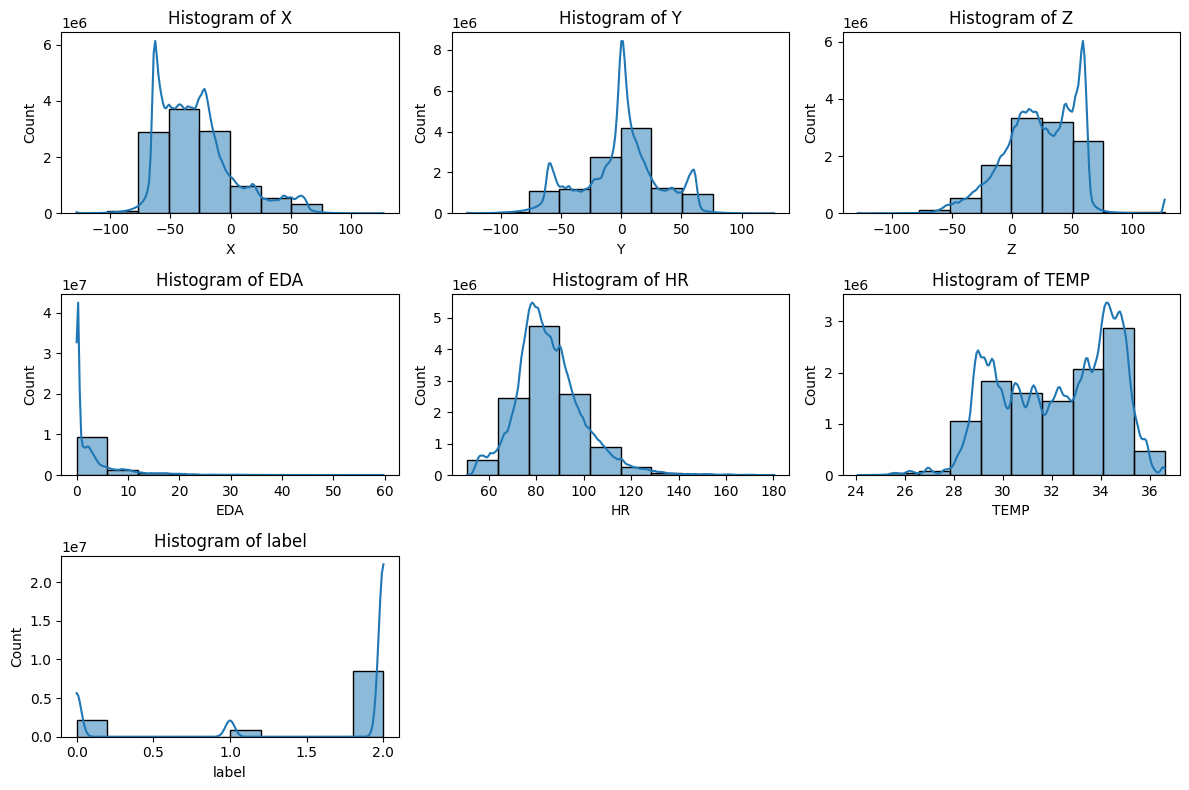

In [9]:
plt.figure(figsize=(12, 8))
columns = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'label']
for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df2[col], kde=True, bins=10)
    plt.title(f'Histogram of {col}')

plt.tight_layout()

plt.show()

In [8]:
df2['datetime'] = pd.to_datetime(df2['datetime'])

# Set datetime as the index
df2.set_index('datetime', inplace=True)



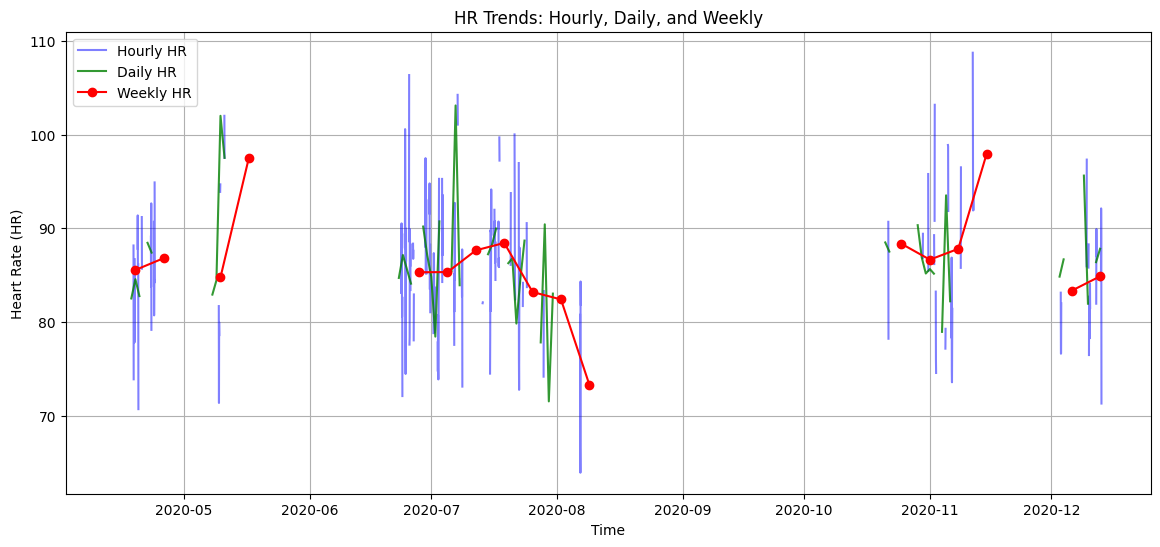

In [9]:
#add hourly, daily, weekly attributes to capture trends
hr_hourly = df2['HR'].resample('h').mean()
hr_daily = df2['HR'].resample('D').mean()
hr_weekly = df2['HR'].resample('W').mean()
data_hourly = df2[['X', 'Y', 'Z', 'EDA', 'HR']].resample('h').mean()


plt.figure(figsize=(14, 6))

# Plot all hourly, daily and weekly trends
plt.plot(hr_hourly, linestyle='-', alpha=0.5, color='blue', label='Hourly HR')
plt.plot(hr_daily, linestyle='-', alpha=0.8, color='green', label='Daily HR')
plt.plot(hr_weekly, linestyle='-', alpha=1.0, color='red', marker='o', label='Weekly HR')
plt.xlabel("Time")
plt.ylabel("Heart Rate (HR)")
plt.title("HR Trends: Hourly, Daily, and Weekly")
plt.legend()
plt.grid(True)

plt.show()




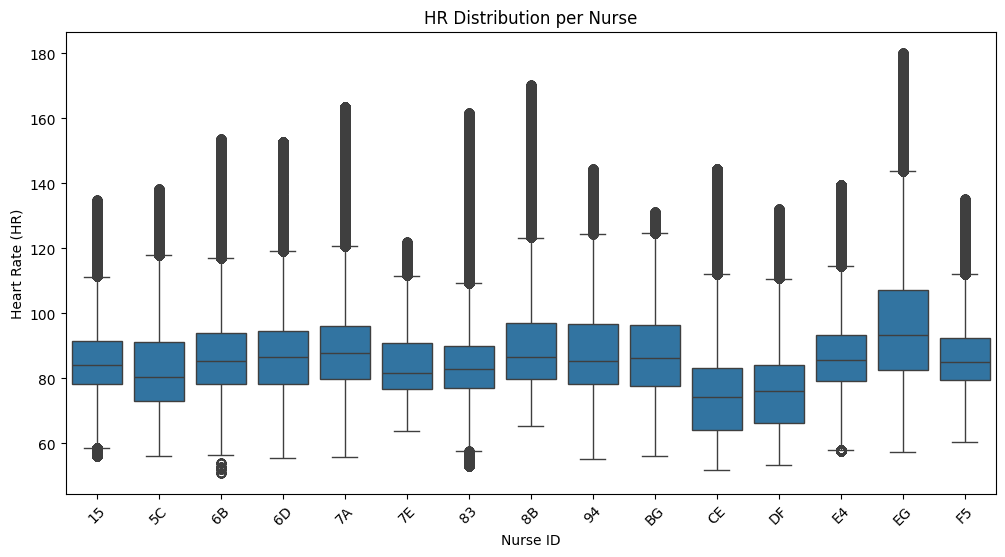

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='HR', data=df2)
plt.title('HR Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('Heart Rate (HR)')
plt.xticks(rotation=45)
plt.show()


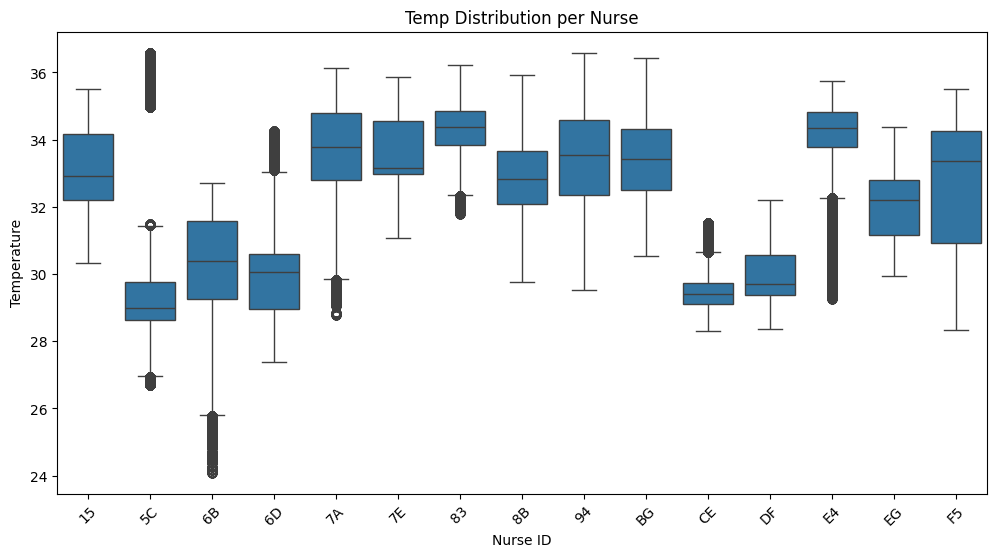

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='TEMP', data=df2)
plt.title('Temp Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()


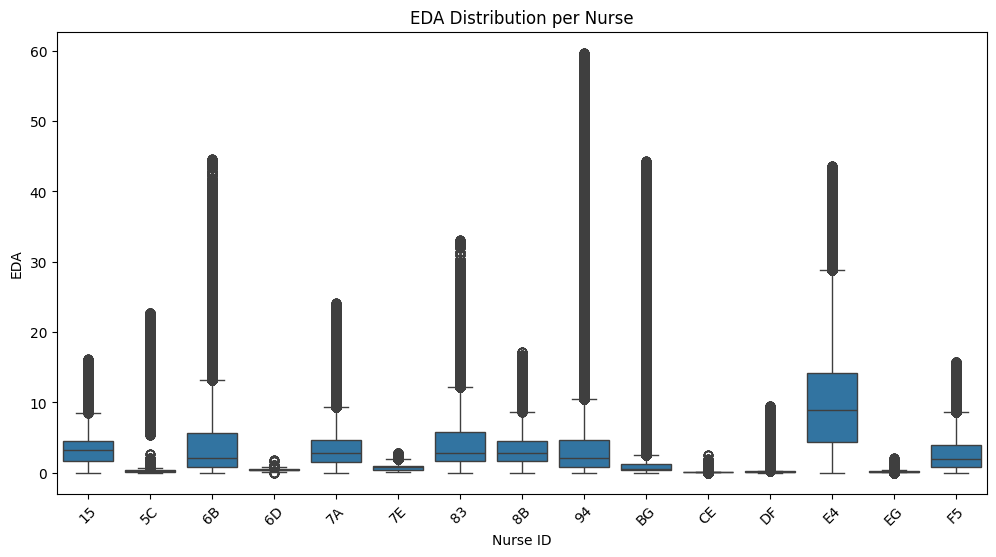

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='EDA', data=df2)
plt.title('EDA Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('EDA')
plt.xticks(rotation=45)
plt.show()


In [10]:
df2 = df2.reset_index()  
df2['datetime'] = pd.to_datetime(df2['datetime']) 

In [11]:
print(df2.dtypes)

datetime    datetime64[ns]
X                  float64
Y                  float64
Z                  float64
EDA                float64
HR                 float64
TEMP               float64
id                  object
label                int32
dtype: object


In [12]:
df2 = df2.reset_index()  
df2['datetime'] = pd.to_datetime(df2['datetime']) 

### Feature Engineering

In [13]:
df2["day_of_week"] = df2["datetime"].dt.dayofweek
df2["month"] = df2["datetime"].dt.month
df2["day_of_month"] = df2["datetime"].dt.day

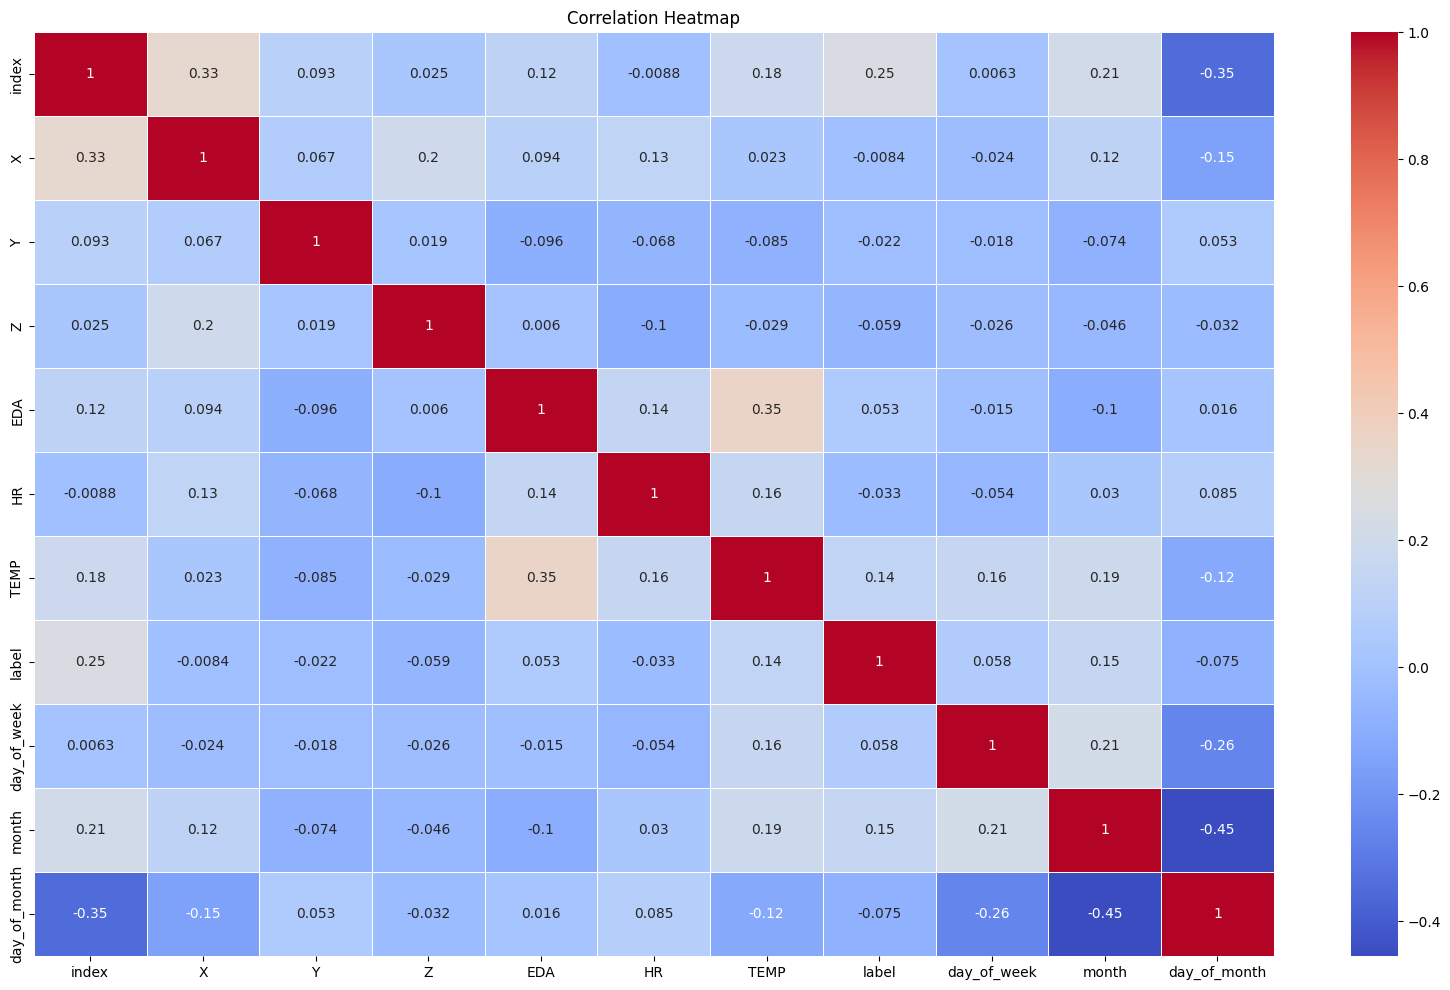

In [19]:
plt.figure(figsize=(20,12))
sns.heatmap(df2.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df2['id_encoded'] = label_encoder.fit_transform(df2['id'])

## Modelling

### Random Forest

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # Use SMOTE instead of RandomOverSampler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Removing Duplicates & Prepare Data
df_cleaned = df2.drop_duplicates()

# Convert Data Types to Reduce Memory Usage
features = df_cleaned.drop(columns=['id', 'id_encoded', 'label', 'datetime']).astype(np.float32)
target = df_cleaned['label'].astype(np.int32)

# Ensuring Label 1 Appears in Train & Test
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=42
)

# Applying SMOTE Instead of RandomOverSampler to Reduce Memory
#smote = SMOTE(sampling_strategy={0: 3_500_000, 1: 3_500_000, 2: 6_832_466}, random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#print("Before SMOTE:", np.unique(y_train, return_counts=True))
#print("After SMOTE:", np.unique(y_train_resampled, return_counts=True))


resampling_pipeline = Pipeline([
    # SMOTE will only oversample the minority class (1) to balance with Class 0
    ("smote", SMOTE(sampling_strategy={1: 1_729_797}, random_state=42)),
    
    # RandomUnderSampler to reduce the majority class (2) to 3,500,000
    ("under", RandomUnderSampler(sampling_strategy={2: 3_500_000}, random_state=42))
])
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)

print("After SMOTE:", np.unique(y_train_resampled, return_counts=True))

#Initialize Optimized Random Forest
rf_model = RandomForestClassifier(
    n_estimators=30,      # using optimal num of trees
    max_depth=15,         # tree depth limit
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced_subsample",  # To ensure class 1 is not ignored
    random_state=42,
    n_jobs=4              # To limit CPU usage
)

rf_model.fit(X_train_resampled, y_train_resampled)

#Predict on Test Set
y_pred = rf_model.predict(X_test)

# Evaluate Model
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


After SMOTE: (array([0, 1, 2]), array([1729797, 1729797, 3500000], dtype=int64))


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap")
plt.show()



### LSTM


In [16]:
df_cleaned = df_cleaned.reset_index(drop=True)


In [17]:

subset_size= int(len(df_cleaned) * 0.001)



#take random data subset
df_subset = df_cleaned.iloc[:subset_size]

#split data subset 80/20 for train/validation
split_pos = int(len(df_subset) * 0.8)
train_df = df_subset.iloc[:split_pos]
val_df = df_subset.iloc[split_pos:] 

In [18]:
#reset the indices 
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [19]:
seq_arrays = []
seq_labs = []

In [57]:



import numpy as np
from sklearn.preprocessing import StandardScaler

# Define sequence length and prediction horizon
seq_length = 60  # Use last 60 minutes of data
ph = 15  # Predict 15 minutes ahead

# Features to use for prediction
feat_cols = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']  # Ensure 'EDA' is included

# Standardize the dataset
scaler = StandardScaler()
train_df[feat_cols] = scaler.fit_transform(train_df[feat_cols])  # Fit & transform on train data
val_df[feat_cols] = scaler.transform(val_df[feat_cols])  # Transform validation data

# Convert dataset into sequences
gap_values = train_df[feat_cols].values
seq_arrays, seq_eda = [], []

for i in range(len(gap_values) - seq_length - ph):
    # Input sequence for the past 60 minutes
    seq = gap_values[i: i + seq_length]

    # Output: Predict EDA value 15 minutes ahead
    eda_value = gap_values[i + seq_length + ph - 1][3]  # Index 3 corresponds to 'EDA'

    seq_arrays.append(seq)
    seq_eda.append(eda_value)

# Convert lists to numpy arrays
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_eda = np.array(seq_eda, dtype=np.float32)

print(f"Sequence shape: {seq_arrays.shape}")  # Expected: (num_samples, 60, num_features)
print(f"EDA shape: {seq_eda.shape}")  # Expected: (num_samples,)



Sequence shape: (9132, 60, 6)
EDA shape: (9132,)


In [58]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [59]:
seq_arrays.shape

(9132, 60, 6)

In [211]:
model_path = 'LSTM_model1.keras'

# building the network
nb_features = seq_arrays.shape[2] 
nb_out = 1

model = Sequential()

#adding first LSTM layer
model.add(LSTM(
         input_shape=(seq_arrays.shape[1], nb_features),
         units=64, 
         return_sequences=True))
model.add(Dropout(0.25)) 

# adding second LSTM layer
model.add(LSTM(
          units=128,
          return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=nb_out))
  
model.add(Activation('linear'))

optimizer = keras.optimizers.Adam(learning_rate = 0.0003)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

    


# fiting the network
history = model.fit(seq_arrays, seq_labs, epochs=150, batch_size=64, validation_split=0.05, verbose=2,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min'), 
                    keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                   ) 

# list all data in history
print(history.history.keys())

C:\Users\dpamu\miniconda3\envs\test_pdf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
136/136 - 27s - 196ms/step - loss: 0.3784 - mse: 0.3784 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 2/150
136/136 - 20s - 144ms/step - loss: 0.3223 - mse: 0.3223 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 3/150
136/136 - 19s - 143ms/step - loss: 0.3111 - mse: 0.3111 - val_loss: 0.0538 - val_mse: 0.0538
Epoch 4/150
136/136 - 19s - 142ms/step - loss: 0.2922 - mse: 0.2922 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 5/150
136/136 - 19s - 141ms/step - loss: 0.2676 - mse: 0.2676 - val_loss: 0.0599 - val_mse: 0.0599
Epoch 6/150
136/136 - 19s - 140ms/step - loss: 0.2422 - mse: 0.2422 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 7/150
136/136 - 20s - 144ms/step - loss: 0.2265 - mse: 0.2265 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 8/150
136/136 - 19s - 143ms/step - loss: 0.2134 - mse: 0.2134 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 9/150
136/136 - 19s - 143ms/step - loss: 0.2066 - mse: 0.2066 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 10/150
136/136 - 20s - 143ms/step - loss: 0.1896 

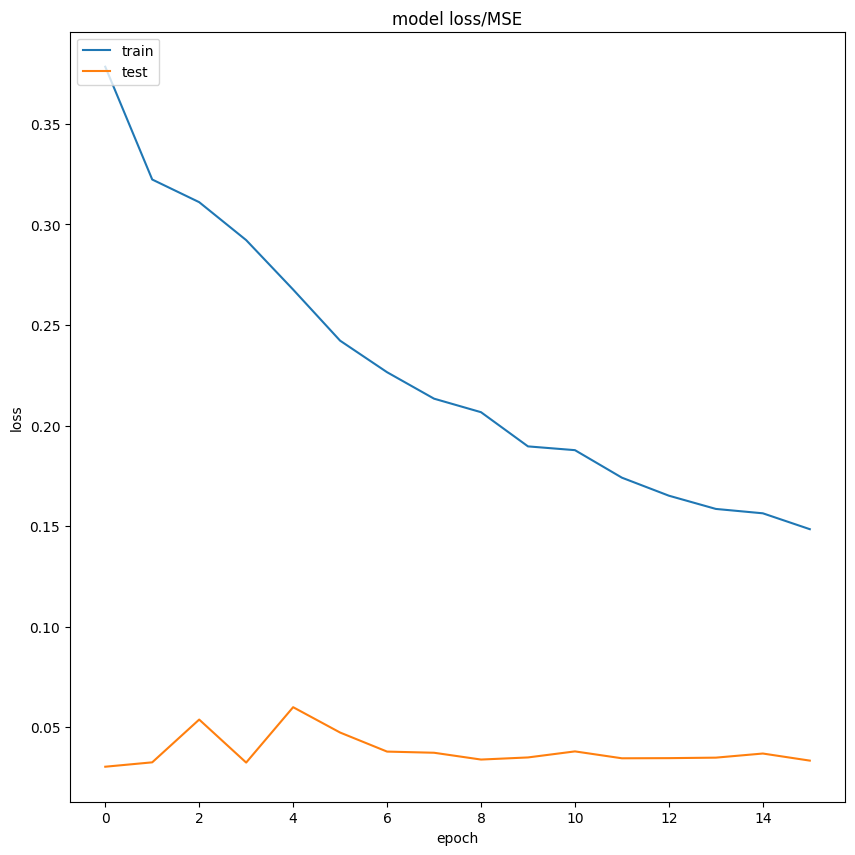

In [212]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [213]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
seq_length = 90   
ph = 5            # Predictive horizon 

 # Choosing all relevant features
feat_cols = ['X', 'Y', 'Z', 'HR', 'EDA', 'TEMP'] 


# Extract GAP values from your validation set
gap_values_val = val_df[feat_cols].values
labels_val = val_df['EDA'].values  # Keep labels separately


# Create sequences starting with seq length
for i in range(len(gap_values_val) - seq_length - ph):
    # Extract sequence of past `seq_length` feature readings
    gap_sequence = gap_values_val[i: i + seq_length]
    
    # Append sequence to val_arrays
    val_arrays.append(gap_sequence)

    # The label is at `seq_length + ph - 1`
    gap_label = gap_values_val[i + seq_length + ph - 1, feat_cols.index('EDA')]  
    val_labs.append(gap_label)

# Convert lists to NumPy arrays
val_arrays = np.array(val_arrays, dtype=np.float32)  
val_labs = np.array(val_labs, dtype=np.float32) 

69/69 - 6s - 88ms/step - loss: 2.4444 - mse: 2.4444

MSE: 2.4444026947021484
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step


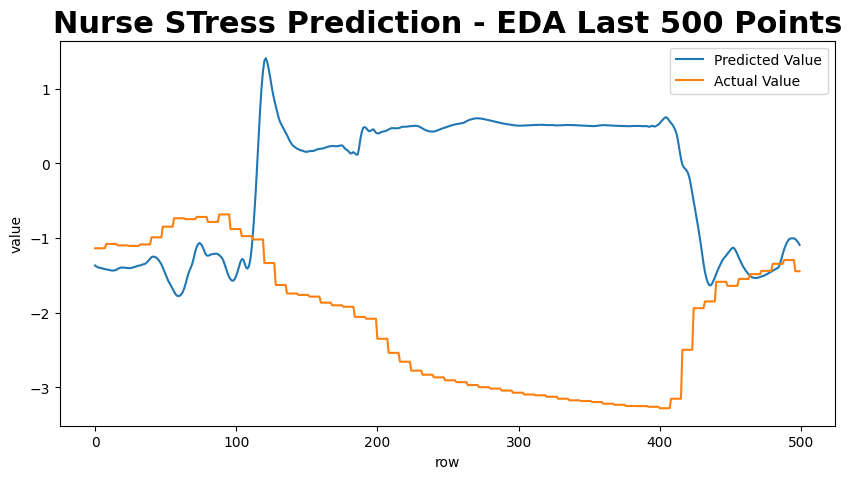

In [214]:

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)


# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Nurse STress Prediction - EDA Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")